In [1]:
import time
from datetime import datetime
import pandas as pd
from prophet import Prophet

/Users/olestole/code/unibo/iot/air-quality-monitoring/backend/venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS

org = ""
bucket = ""
token = ""
host = ""
port = "8086"
url = f"http://{host}:{port}"

client = InfluxDBClient(url=url, token=token, org=org)
query_api = client.query_api()
write_api = client.write_api(write_options=SYNCHRONOUS)

In [3]:
client.health()

{'checks': [],
 'commit': 'a2f8538837',
 'message': 'ready for queries and writes',
 'name': 'influxdb',
 'status': 'pass',
 'version': 'v2.2.0'}

In [4]:
start = 6
measurement = "rss"

query_sensor = 'from(bucket:"air-quality")' \
        f' |> range(start:-{start}h, stop: 0h)'\
        f' |> filter(fn: (r) => r["_measurement"] == "{measurement}")' \
        ' |> aggregateWindow(every: 5s, fn: mean, createEmpty: false)'

query_forecast = 'from(bucket:"air-quality-forecast")' \
        f' |> range(start:-{start}h, stop: 0h)'\
        f' |> filter(fn: (r) => r["_measurement"] == "{measurement}")' \
        ' |> aggregateWindow(every: 5s, fn: mean, createEmpty: false)'

In [5]:
result_sensor = client.query_api().query(org=org, query=query_sensor)
result_forecast = client.query_api().query(org=org, query=query_forecast)

In [6]:
def create_raw(result):
    raw = []
    for table in result:
        for record in table.records:
            raw.append((record.get_value(), record.get_time()))
    return raw

raw_sensor = create_raw(result_sensor)
raw_forecast = create_raw(result_forecast)

In [7]:
def create_dataframe(raw):
    df=pd.DataFrame(raw, columns=['y','ds'], index=None)
    df['ds'] = df['ds'].values.astype('<M8[s]')
    df['ds'] +=  pd.to_timedelta(2, unit='h')
    df.set_index('ds')
    return df

df_forecast = create_dataframe(raw_forecast)
df_sensor = create_dataframe(raw_sensor)

In [8]:
def drop_duplicates(df):
    df.drop_duplicates(subset='ds', keep='last', inplace=True)
    df.set_index('ds', inplace=True)
    return df

df_sensor = drop_duplicates(df_sensor)
df_forecast = drop_duplicates(df_forecast)

In [9]:
# Align the indexes of the two dataframes by using pandas join
joined_df = df_sensor.join(df_forecast, how='outer', rsuffix='_1')

In [10]:
# Drop columns in joined_df where y or y_1 is NaN
joined_df.dropna(subset=['y', 'y_1'], inplace=True)
joined_df.head()

,y,y_1
ds,,
2022-05-22 10:45:05,-59.000000,-56.107157
2022-05-22 10:46:05,-58.666667,-55.904687
2022-05-22 10:47:05,-58.666667,-56.208564
2022-05-22 10:48:05,-56.333333,-56.165652
2022-05-22 10:49:05,-56.666667,-56.022134


In [11]:
def mse(df):
    return ((df['y'] - df['y_1'])**2).mean()

timseries_mse = mse(joined_df)
timseries_mse

26.1243488441665

# New section

In [223]:

s11, s12 = df_forecast.align(df_sensor, join='inner', axis=0)

2022-05-22 13:58:20 2022-05-22 13:58:15
2022-05-22 13:58:25 2022-05-22 13:58:20
2022-05-22 13:58:30 2022-05-22 13:58:25
2022-05-22 13:58:35 2022-05-22 13:58:30
2022-05-22 13:58:40 2022-05-22 13:58:35
2022-05-22 13:58:45 2022-05-22 13:58:40
2022-05-22 13:58:55 2022-05-22 13:58:45
2022-05-22 13:59:00 2022-05-22 13:58:50
2022-05-22 13:59:05 2022-05-22 13:58:55
2022-05-22 13:59:10 2022-05-22 13:59:00
2022-05-22 13:59:15 2022-05-22 13:59:05
2022-05-22 13:59:20 2022-05-22 13:59:10
2022-05-22 13:59:25 2022-05-22 13:59:15
2022-05-22 13:59:30 2022-05-22 13:59:20
2022-05-22 13:59:35 2022-05-22 13:59:25
2022-05-22 13:59:40 2022-05-22 13:59:30
2022-05-22 13:59:45 2022-05-22 13:59:35
2022-05-22 13:59:50 2022-05-22 13:59:40
2022-05-22 13:59:55 2022-05-22 13:59:45
2022-05-22 14:00:05 2022-05-22 13:59:50
2022-05-22 14:00:10 2022-05-22 13:59:55
2022-05-22 14:00:15 2022-05-22 14:00:00
2022-05-22 14:00:20 2022-05-22 14:00:05
2022-05-22 14:00:25 2022-05-22 14:00:10
2022-05-22 14:00:30 2022-05-22 14:00:15


In [227]:
for i in range(len(s11)):
    print(s11['ds'][i], s12['ds'][i])

2022-05-22 13:58:20 2022-05-22 13:58:15
2022-05-22 13:58:25 2022-05-22 13:58:20
2022-05-22 13:58:30 2022-05-22 13:58:25
2022-05-22 13:58:35 2022-05-22 13:58:30
2022-05-22 13:58:40 2022-05-22 13:58:35
2022-05-22 13:58:45 2022-05-22 13:58:40
2022-05-22 13:58:55 2022-05-22 13:58:45
2022-05-22 13:59:00 2022-05-22 13:58:50
2022-05-22 13:59:05 2022-05-22 13:58:55
2022-05-22 13:59:10 2022-05-22 13:59:00
2022-05-22 13:59:15 2022-05-22 13:59:05
2022-05-22 13:59:20 2022-05-22 13:59:10
2022-05-22 13:59:25 2022-05-22 13:59:15
2022-05-22 13:59:30 2022-05-22 13:59:20
2022-05-22 13:59:35 2022-05-22 13:59:25
2022-05-22 13:59:40 2022-05-22 13:59:30
2022-05-22 13:59:45 2022-05-22 13:59:35
2022-05-22 13:59:50 2022-05-22 13:59:40
2022-05-22 13:59:55 2022-05-22 13:59:45
2022-05-22 14:00:05 2022-05-22 13:59:50
2022-05-22 14:00:10 2022-05-22 13:59:55
2022-05-22 14:00:15 2022-05-22 14:00:00
2022-05-22 14:00:20 2022-05-22 14:00:05
2022-05-22 14:00:25 2022-05-22 14:00:10
2022-05-22 14:00:30 2022-05-22 14:00:15


In [191]:
df_sensor['ds'] = df_sensor['ds'].drop_duplicates()

In [192]:
df_sensor = df_sensor.reset_index()

In [194]:
df_forecast = df_forecast.dropna()
df_forecast = df_forecast.reset_index()

In [195]:
df_sensor.axes

[RangeIndex(start=0, stop=719, step=1),
 Index(['index', 'y', 'ds'], dtype='object')]

In [196]:
s11, s12 = df_forecast.align(df_sensor, axis=1)

In [197]:
s12

,index,y,ds
0,0,49.50,2022-05-22 13:54:30
1,1,49.50,2022-05-22 13:54:35
2,2,49.50,2022-05-22 13:54:40
3,3,49.50,2022-05-22 13:54:45
4,4,49.60,2022-05-22 13:54:50
...,...,...,...
714,714,51.65,2022-05-22 14:54:10
715,715,51.60,2022-05-22 14:54:15
716,716,51.65,2022-05-22 14:54:20
717,717,51.60,2022-05-22 14:54:25


In [198]:
aligned = 0
misaligned = 0

df_forecast
for i in range(len(df_forecast)):

    if s11['ds'][i] == s12['ds'][i]:
        aligned += 1
    else:
        
        misaligned += 1
    
print(f"{s11['ds'][i]} - {s12['ds'][i]} - {aligned} - {misaligned}")


2022-05-22 14:54:28 - 2022-05-22 14:48:45 - 9 - 641


# Prediction

In [19]:
query = 'import "timezone"' \
        'option location = timezone.fixed(offset: -8h)' \
        'from(bucket:"air-quality")' \
        ' |> range(start:-24h, stop: 0h)'\
        ' |> filter(fn: (r) => r["_measurement"] == "hum")' \
        ' |> aggregateWindow(every: 1m, fn: mean, createEmpty: false)'

In [20]:
result = client.query_api().query(org=org, query=query)

In [21]:
raw = []
for table in result:
    for record in table.records:
        raw.append((record.get_value(), record.get_time()))
print(raw[0:5])

[(54.96153846153846, datetime.datetime(2022, 5, 20, 14, 3, tzinfo=tzutc())), (55.04999999999998, datetime.datetime(2022, 5, 20, 14, 4, tzinfo=tzutc())), (55.37096774193547, datetime.datetime(2022, 5, 20, 14, 5, tzinfo=tzutc())), (55.41666666666665, datetime.datetime(2022, 5, 20, 14, 6, tzinfo=tzutc())), (55.41000000000002, datetime.datetime(2022, 5, 20, 14, 7, tzinfo=tzutc()))]


In [26]:
print("\n=== influxdb query into dataframe ===\n")
df=pd.DataFrame(raw, columns=['y','ds'], index=None)
df['ds'] = df['ds'].values.astype('<M8[s]')
df['ds'] +=  pd.to_timedelta(2, unit='h')
df.set_index('ds')
df


=== influxdb query into dataframe ===



,y,ds
0,54.961538,2022-05-20 16:03:00
1,55.050000,2022-05-20 16:04:00
2,55.370968,2022-05-20 16:05:00
3,55.416667,2022-05-20 16:06:00
4,55.410000,2022-05-20 16:07:00
...,...,...
109,49.929032,2022-05-21 15:59:00
110,49.789655,2022-05-21 16:00:00
111,49.673333,2022-05-21 16:01:00
112,49.630000,2022-05-21 16:02:00


In [144]:
df['y'] = df['y'].apply(lambda x: round(x, 2))

In [117]:
df.head()

,y,ds
0,54.84,2022-05-20 13:58:00
1,54.74,2022-05-20 13:59:00
2,54.71,2022-05-20 14:00:00
3,54.74,2022-05-20 14:01:00
4,54.95,2022-05-20 14:02:00


In [118]:
m = Prophet()
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02253
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       536.964    0.00143415       153.469      0.7086      0.7086      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       537.174   1.55458e-05       74.9927   2.573e-08       0.001      191  LS failed, Hessian reset 
     118       537.882   6.54375e-06        124.12   5.522e-08       0.001      280  LS failed, Hessian reset 
     130       538.293   8.39316e-06         142.6   1.017e-07       0.001      363  LS failed, Hessian reset 
     144        538.83   2.28739e-05       220.692   3.902e-07       0.001      428  LS failed, Hessian reset 
     182       539.314   1.46269e-05        95.348   2.619e-08       0.001      525  LS failed, Hessian reset 
     199       539.989    0.00119025       90.9642      0.2074           1      552   
    Iter      log prob        ||dx||      ||gr

 failed, Hessian reset 
     282       541.616   1.70332e-05       101.141   2.642e-08       0.001      758  LS failed, Hessian reset 
     294       541.946    1.5069e-05       221.931   1.315e-07       0.001      810  LS failed, Hessian reset 
     299       542.274   0.000848481       132.308           1           1      817   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357       542.652   6.97722e-06       94.2533       3e-08       0.001      940  LS failed, Hessian reset 
     399        542.76   7.94447e-05       88.1767           1           1      994   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     431       542.995   8.02538e-05       366.554   8.988e-07       0.001     1104  LS failed, Hessian reset 
     499       543.178   0.000370767       112.688           1           1     1196   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  No

In [108]:
future = m.make_future_dataframe(periods=48, freq='5S', include_history=False)
future

,ds
0,2022-05-21 13:54:55
1,2022-05-21 13:55:00
2,2022-05-21 13:55:05
3,2022-05-21 13:55:10
4,2022-05-21 13:55:15
5,2022-05-21 13:55:20
6,2022-05-21 13:55:25
7,2022-05-21 13:55:30
8,2022-05-21 13:55:35
9,2022-05-21 13:55:40


In [74]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
7,2022-05-21 13:51:24,49.438519,49.119604,49.783120
8,2022-05-21 13:51:29,49.437745,49.096256,49.786611
9,2022-05-21 13:51:34,49.436971,49.104560,49.764602
10,2022-05-21 13:51:39,49.436197,49.115317,49.768513
11,2022-05-21 13:51:44,49.435423,49.118633,49.776015


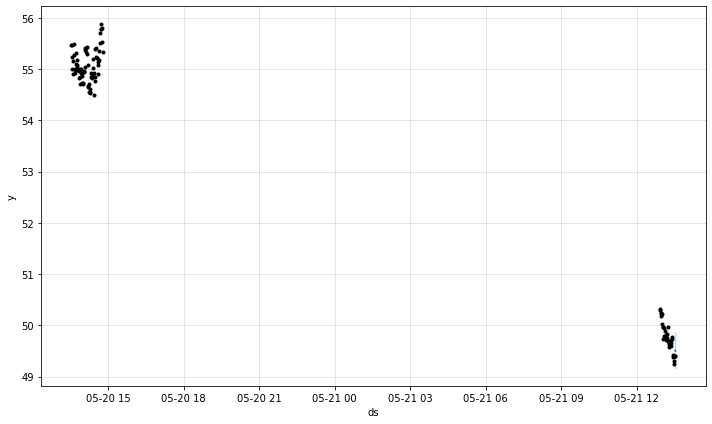

In [55]:
fig1 = m.plot(forecast)

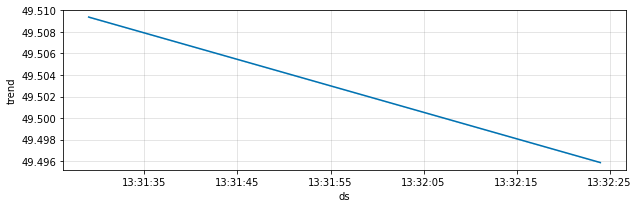

In [56]:
fig2 = m.plot_components(forecast)


In [109]:
forecast['measurement'] = "hum"

In [110]:
cp = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','measurement']].copy()
lines = [str(cp["measurement"][d]) 
         + ",type=forecast" 
         + " " 
         + "yhat=" + str(cp["yhat"][d]) + ","
         + "yhat_lower=" + str(cp["yhat_lower"][d]) + ","
         + "yhat_upper=" + str(cp["yhat_upper"][d])
         + " " + str(int(time.mktime(cp['ds'][d].timetuple()))) + "000000000" for d in range(len(cp))]

In [ ]:
lines